In [1]:
import gensim
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import os
from collections import defaultdict
import tqdm
import numpy as np
import re
from nltk.tokenize import word_tokenize
import random
from itertools import chain
import embeddings_functions
import time
import pandas as pd
from collections import Counter
from joblib import Parallel, delayed
from multiprocessing import cpu_count
from itertools import product
import spacy
import nltk
from nltk.corpus import wordnet
from langdetect import detect

In [2]:
for dirname, _, filenames in os.walk('data/yelp'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
df = pd.read_json("data/yelp/yelp_academic_dataset_review.json", encoding = 'ISO-8859-1', lines=True,nrows=200000)
df_proc = df[["text"]].reset_index()

def preprocess_text(text):
    text = re.sub(r'[\W\d_]', ' ', text)  
    text = text.lower()  
    return text

df_proc['text'] = df_proc['text'].apply(preprocess_text)

data/yelp\Dataset_User_Agreement.pdf
data/yelp\yelp_academic_dataset_business.json
data/yelp\yelp_academic_dataset_checkin.json
data/yelp\yelp_academic_dataset_review.json
data/yelp\yelp_academic_dataset_tip.json
data/yelp\yelp_academic_dataset_user.json


In [3]:
len(df_proc)

200000

In [4]:
df_proc['language'] = df_proc['text'].apply(lambda x: detect(x))
df_proc = df_proc[df_proc['language'] == 'en']

In [5]:
len(df_proc)

199781

## Parameters

In [6]:
#df_proc = pd.DataFrame({'text': [
#    "apple pie",
#    "she bought banana",
#    "he drinks orange juice",
#    "test1 test2",
#    "test1 test3",  
#]})

In [7]:
df_proc['text_tok'] = df_proc['text'].apply(word_tokenize)
df_proc

,index,text,language,text_tok
0,0,if you decide to eat here just be aware it is...,en,"[if, you, decide, to, eat, here, just, be, awa..."
1,1,i ve taken a lot of spin classes over the year...,en,"[i, ve, taken, a, lot, of, spin, classes, over..."
2,2,family diner had the buffet eclectic assortm...,en,"[family, diner, had, the, buffet, eclectic, as..."
3,3,wow yummy different delicious our favo...,en,"[wow, yummy, different, delicious, our, favori..."
4,4,cute interior and owner gave us tour of up...,en,"[cute, interior, and, owner, gave, us, tour, o..."
...,...,...,...,...
199995,199995,oakley s bistro is a hidden gem for indianapol...,en,"[oakley, s, bistro, is, a, hidden, gem, for, i..."
199996,199996,let me just say i m glad my husband and i dec...,en,"[let, me, just, say, i, m, glad, my, husband, ..."
199997,199997,i was coming back from the farmers market toda...,en,"[i, was, coming, back, from, the, farmers, mar..."
199998,199998,absolutely perfect meal for me the food is cl...,en,"[absolutely, perfect, meal, for, me, the, food..."


## Embeddings

In [8]:
model_name = "second"
word_embeddings = embeddings_functions.Word2VecEmbeddings(df_proc['text_tok'].tolist(),model_name)
word_embeddings.train_model(window = 3,min_count = 1, seed = 1,sg = 1,vector_size=100,norm = True, sample = None,epochs = 5)

trained


In [9]:
flattened_list = list(chain(*df_proc['text_tok'].tolist()))
print(len(flattened_list))

20511799


In [10]:
flattened_list_s = random.sample(flattened_list, 10000)
embeddings = word_embeddings.get_embeddings(words = flattened_list_s)
similarity = embeddings_functions.Similarity2(embeddings_df = embeddings)
df_cosine = similarity.get_cosine_similarity_of_all_words2().drop_duplicates()

In [11]:
df_cosine

,similarity,First,Last
0,0.300317,type,when
1,0.395349,type,would
2,0.253379,type,followed
3,0.204571,type,she
4,0.265206,type,always
...,...,...,...
2503198,0.421382,recipe,saki
2503199,0.238683,recipe,intimate
2503200,0.318745,clayton,saki
2503201,0.334505,clayton,intimate


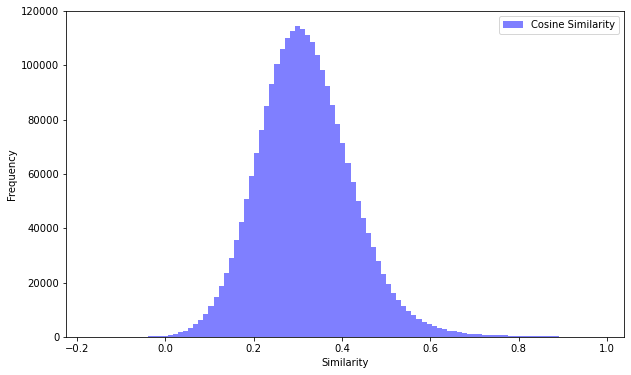

In [12]:
plt.figure(figsize=(10, 6))
plt.hist(df_cosine["similarity"], bins=100, color="blue", alpha=0.5, label="Cosine Similarity")
plt.xlabel("Similarity")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [13]:
def co_occurrence_corr(sentences, window_size):
    
    d = defaultdict(int)
    vocab = set()
    
    # Vytvoření slovníku četností slov
    for text in tqdm.tqdm(sentences):
        for i in range(len(text)):
            token = text[i]
            vocab.add(token)  # add to vocab
            next_tokens = text[i+1 : i+1+window_size]
            for next_token in next_tokens:
                key = tuple(sorted([next_token, token]))
                d[key] += 1
                
    # Vytvoření matice frekvencí
    vocab = sorted(vocab) # Seřazení slovníku
    vocab_index = {word: i for i, word in enumerate(vocab)}
    
    co_occurrence_matrix = np.zeros((len(vocab), len(vocab)), dtype=np.int)
    for (token1, token2), value in tqdm.tqdm(d.items()):
        index1 = vocab_index[token1]
        index2 = vocab_index[token2]
        co_occurrence_matrix[index1, index2] = value
        co_occurrence_matrix[index2, index1] = value 
    print("done")
    
    #correlation_matrix = np.corrcoef(co_occurrence_matrix)
    word_pairs = [(row['First'], row['Last']) for _, row in df_cosine.iterrows()]
    correlations = []
    for word_pair in tqdm.tqdm(word_pairs):
        word1, word2 = word_pair
        index1 = vocab_index[word1]
        index2 = vocab_index[word2]
        correlation = np.corrcoef(co_occurrence_matrix[index1], co_occurrence_matrix[index2])
        correlation = correlation[0, 1]
        correlations.append(correlation)
        
    return co_occurrence_matrix, vocab_index, correlations

In [14]:
window_size = 3
co_occurrence_matrix,vocab_index,correlations = co_occurrence_corr(df_proc["text_tok"].to_list(), window_size)

100%|████████████████████████████████████████████████████████████████████████| 199781/199781 [00:57<00:00, 3446.52it/s]
C:\Users\berl03\AppData\Local\Temp/ipykernel_20768/2352195706.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  co_occurrence_matrix = np.zeros((len(vocab), len(vocab)), dtype=np.int)
100%|████████████████████████████████████████████████████████████████████| 5440224/5440224 [00:14<00:00, 377920.50it/s]


done


100%|███████████████████████████████████████████████████████████████████████| 2503203/2503203 [44:50<00:00, 930.25it/s]


In [15]:
df_cosine["corr"] = correlations

In [16]:
frekvence_slov = Counter()
for dokument in df_proc["text_tok"].to_list():
    frekvence_slov.update(dokument)
 
def ziskej_frekvenci(slovo):
    return frekvence_slov.get(slovo, 0)

In [17]:
data = []
for index, row in df_cosine.drop_duplicates().iterrows():
    word1 = row["First"]
    word2 = row["Last"]
    index_w1 = vocab_index[word1]
    index_w2 = vocab_index[word2]
    frequency = co_occurrence_matrix[index_w1, index_w2]
    
    row_data = {
        "First": word1,
        "Last": word2,
        "Frequency": frequency,
        "frequency_First":ziskej_frekvenci(word1),
        "frequency_Last":ziskej_frekvenci(word2),
    }
    data.append(row_data)
res = pd.DataFrame(data)

In [18]:
res

,First,Last,Frequency,frequency_First,frequency_Last
0,type,when,17,3401,53246
1,type,would,23,3401,53755
2,type,followed,0,3401,815
3,type,she,22,3401,39663
4,type,always,9,3401,29915
...,...,...,...,...,...
2503198,recipe,saki,0,495,95
2503199,recipe,intimate,0,495,895
2503200,clayton,saki,0,216,95
2503201,clayton,intimate,0,216,895


In [19]:
res["First_Last"] = res["First"]+"_"+res["Last"]
df_cosine = df_cosine.drop_duplicates()
df_cosine["First_Last"] = df_cosine["First"]+"_"+df_cosine["Last"]
res = df_cosine.merge(res[["First_Last","Frequency","frequency_First","frequency_Last"]], on=["First_Last"], how = "inner").drop_duplicates()
res.columns = ["cosine_similarity","first_word","second_word","correlation_of_context","first_second","frequency_co_occurrence","frequency_w1","frequency_w2"]
res

,cosine_similarity,first_word,second_word,correlation_of_context,first_second,frequency_co_occurrence,frequency_w1,frequency_w2
0,0.300317,type,when,0.512748,type_when,17,3401,53246
1,0.395349,type,would,0.440563,type_would,23,3401,53755
2,0.253379,type,followed,0.503107,type_followed,0,3401,815
3,0.204571,type,she,0.511910,type_she,22,3401,39663
4,0.265206,type,always,0.541555,type_always,9,3401,29915
...,...,...,...,...,...,...,...,...
2503198,0.421382,recipe,saki,0.738245,recipe_saki,0,495,95
2503199,0.238683,recipe,intimate,0.685028,recipe_intimate,0,495,895
2503200,0.318745,clayton,saki,0.666173,clayton_saki,0,216,95
2503201,0.334505,clayton,intimate,0.597443,clayton_intimate,0,216,895


In [28]:
total_word_count = df_proc['text'].apply(len).sum()

In [29]:
res["no_words_corpus"] = total_word_count

In [30]:
res["tf_rel_word1"] = res["frequency_w1"] / res["no_words_corpus"]*100
res["tf_rel_word2"] = res["frequency_w2"] / res["no_words_corpus"]*100

In [31]:
res

,cosine_similarity,first_word,second_word,correlation_of_context,first_second,frequency_co_occurrence,frequency_w1,frequency_w2,df_word1,no_words_corpus,tf_rel_word1,tf_rel_word2
0,0.300317,type,when,0.512748,type_when,17,3401,53246,3401,109853731,0.003096,0.048470
1,0.395349,type,would,0.440563,type_would,23,3401,53755,3401,109853731,0.003096,0.048933
2,0.253379,type,followed,0.503107,type_followed,0,3401,815,3401,109853731,0.003096,0.000742
3,0.204571,type,she,0.511910,type_she,22,3401,39663,3401,109853731,0.003096,0.036105
4,0.265206,type,always,0.541555,type_always,9,3401,29915,3401,109853731,0.003096,0.027232
...,...,...,...,...,...,...,...,...,...,...,...,...
2503198,0.421382,recipe,saki,0.738245,recipe_saki,0,495,95,495,109853731,0.000451,0.000086
2503199,0.238683,recipe,intimate,0.685028,recipe_intimate,0,495,895,495,109853731,0.000451,0.000815
2503200,0.318745,clayton,saki,0.666173,clayton_saki,0,216,95,216,109853731,0.000197,0.000086
2503201,0.334505,clayton,intimate,0.597443,clayton_intimate,0,216,895,216,109853731,0.000197,0.000815


In [32]:
res['word1_length'] = res['first_word'].apply(len)
res['word2_length'] = res['second_word'].apply(len)
res

,cosine_similarity,first_word,second_word,correlation_of_context,first_second,frequency_co_occurrence,frequency_w1,frequency_w2,df_word1,no_words_corpus,tf_rel_word1,tf_rel_word2,word1_length,word2_length
0,0.300317,type,when,0.512748,type_when,17,3401,53246,3401,109853731,0.003096,0.048470,4,4
1,0.395349,type,would,0.440563,type_would,23,3401,53755,3401,109853731,0.003096,0.048933,4,5
2,0.253379,type,followed,0.503107,type_followed,0,3401,815,3401,109853731,0.003096,0.000742,4,8
3,0.204571,type,she,0.511910,type_she,22,3401,39663,3401,109853731,0.003096,0.036105,4,3
4,0.265206,type,always,0.541555,type_always,9,3401,29915,3401,109853731,0.003096,0.027232,4,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503198,0.421382,recipe,saki,0.738245,recipe_saki,0,495,95,495,109853731,0.000451,0.000086,6,4
2503199,0.238683,recipe,intimate,0.685028,recipe_intimate,0,495,895,495,109853731,0.000451,0.000815,6,8
2503200,0.318745,clayton,saki,0.666173,clayton_saki,0,216,95,216,109853731,0.000197,0.000086,7,4
2503201,0.334505,clayton,intimate,0.597443,clayton_intimate,0,216,895,216,109853731,0.000197,0.000815,7,8


## Ostatní vlastnosti

In [33]:
nltk.download('wordnet')

# Získání synonym a antonym pro každé slovo v sloupcích word1 a word2
def get_synonyms_antonyms(word):
    synonyms = set()
    antonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
            if lemma.antonyms():
                antonyms.add(lemma.antonyms()[0].name())
    return synonyms, antonyms

# kolik synonym je spolecnych pro obe slova
def find_synonym_match(word1, word2):
    syn1, _ = get_synonyms_antonyms(word1)
    syn2, _ = get_synonyms_antonyms(word2)
    intersection_count = len(syn1.intersection(syn2))
    return intersection_count, (intersection_count / max(len(syn1), len(syn2))) if max(len(syn1), len(syn2)) != 0 else 0, len(syn1), len(syn2)

# kolik antonym je spolecnych pro obe slova
def find_antonym_match(word1, word2):
    _, ant1 = get_synonyms_antonyms(word1)
    _, ant2 = get_synonyms_antonyms(word2)
    intersection_count = len(ant1.intersection(ant2))
    return intersection_count, (intersection_count / max(len(ant1), len(ant2))) if max(len(ant1), len(ant2)) != 0 else 0, len(ant1), len(ant2)

res['syn_match'], res['syn_match_perc'], res['syn1_count'], res['syn2_count'] = zip(*res.apply(lambda row: find_synonym_match(row['first_word'], row['second_word']), axis=1))
res['ant_match'], res['ant_match_perc'], res['ant1_count'], res['ant2_count'] = zip(*res.apply(lambda row: find_antonym_match(row['first_word'], row['second_word']), axis=1))

res

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\berl03\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,cosine_similarity,first_word,second_word,correlation_of_context,first_second,frequency_co_occurrence,frequency_w1,frequency_w2,df_word1,no_words_corpus,...,word1_length,word2_length,syn_match,syn_match_perc,syn1_count,syn2_count,ant_match,ant_match_perc,ant1_count,ant2_count
0,0.300317,type,when,0.512748,type_when,17,3401,53246,3401,109853731,...,4,4,0,0.0,6,0,0,0.0,1,0
1,0.395349,type,would,0.440563,type_would,23,3401,53755,3401,109853731,...,4,5,0,0.0,6,0,0,0.0,1,0
2,0.253379,type,followed,0.503107,type_followed,0,3401,815,3401,109853731,...,4,8,0,0.0,6,28,0,0.0,1,2
3,0.204571,type,she,0.511910,type_she,22,3401,39663,3401,109853731,...,4,3,0,0.0,6,0,0,0.0,1,0
4,0.265206,type,always,0.541555,type_always,9,3401,29915,3401,109853731,...,4,6,0,0.0,6,8,0,0.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503198,0.421382,recipe,saki,0.738245,recipe_saki,0,495,95,495,109853731,...,6,4,0,0.0,2,7,0,0.0,0,0
2503199,0.238683,recipe,intimate,0.685028,recipe_intimate,0,495,895,495,109853731,...,6,8,0,0.0,2,13,0,0.0,0,0
2503200,0.318745,clayton,saki,0.666173,clayton_saki,0,216,95,216,109853731,...,7,4,0,0.0,0,7,0,0.0,0,0
2503201,0.334505,clayton,intimate,0.597443,clayton_intimate,0,216,895,216,109853731,...,7,8,0,0.0,0,13,0,0.0,0,0


In [34]:
df = res.copy()

In [35]:
nlp = spacy.load("en_core_web_sm")

# Získání morfo-syntaktických vlastností (POS tags) pro každé slovo v sloupcích word1 a word2 pomocí SpaCy
def get_pos_tags(word):
    doc = nlp(word)
    return [token.pos_ for token in doc]

df['word1_pos_tags'] = df['first_word'].apply(get_pos_tags)
df['word2_pos_tags'] = df['second_word'].apply(get_pos_tags)

In [36]:
stop_words = spacy.lang.en.stop_words.STOP_WORDS
def is_stop_word(word):
    return word in stop_words
df['is_stop_word1'] = df['first_word'].apply(is_stop_word).astype(int)
df['is_stop_word2'] = df['second_word'].apply(is_stop_word).astype(int)
df

,cosine_similarity,first_word,second_word,correlation_of_context,first_second,frequency_co_occurrence,frequency_w1,frequency_w2,df_word1,no_words_corpus,...,syn1_count,syn2_count,ant_match,ant_match_perc,ant1_count,ant2_count,word1_pos_tags,word2_pos_tags,is_stop_word1,is_stop_word2
0,0.300317,type,when,0.512748,type_when,17,3401,53246,3401,109853731,...,6,0,0,0.0,1,0,[NOUN],[SCONJ],0,1
1,0.395349,type,would,0.440563,type_would,23,3401,53755,3401,109853731,...,6,0,0,0.0,1,0,[NOUN],[AUX],0,1
2,0.253379,type,followed,0.503107,type_followed,0,3401,815,3401,109853731,...,6,28,0,0.0,1,2,[NOUN],[VERB],0,0
3,0.204571,type,she,0.511910,type_she,22,3401,39663,3401,109853731,...,6,0,0,0.0,1,0,[NOUN],[PRON],0,1
4,0.265206,type,always,0.541555,type_always,9,3401,29915,3401,109853731,...,6,8,0,0.0,1,1,[NOUN],[ADV],0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503198,0.421382,recipe,saki,0.738245,recipe_saki,0,495,95,495,109853731,...,2,7,0,0.0,0,0,[NOUN],[VERB],0,0
2503199,0.238683,recipe,intimate,0.685028,recipe_intimate,0,495,895,495,109853731,...,2,13,0,0.0,0,0,[NOUN],[VERB],0,0
2503200,0.318745,clayton,saki,0.666173,clayton_saki,0,216,95,216,109853731,...,0,7,0,0.0,0,0,[PROPN],[VERB],0,0
2503201,0.334505,clayton,intimate,0.597443,clayton_intimate,0,216,895,216,109853731,...,0,13,0,0.0,0,0,[PROPN],[VERB],0,0


In [37]:
df["pos_tag_eq"] = df["word1_pos_tags"] == df["word2_pos_tags"]
df["pos_tag_eq"] = df["pos_tag_eq"].astype(int)

In [38]:
df.to_csv("df_prep_2.csv")